Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.3 MB/s 
     |████████████████████████████████| 101 kB 10.3 MB/s 
     |████████████████████████████████| 6.6 MB 69.4 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9968c174d8cf26b953edbb80ddcdfc1ab1ec182de184729ceccb4932a037638d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'I-test', 'B-problem', 'O', 'I-problem', 'I-treatment', 'B-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'I-test', 'B-problem', 'O', 'I-problem', 'I-treatment', 'B-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'I-test', 'B-problem', 'O', 'I-problem', 'I-treatment', 'B-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

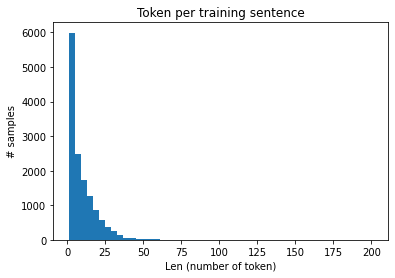

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

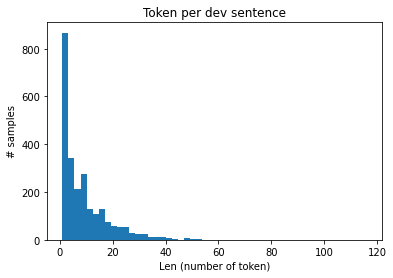

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

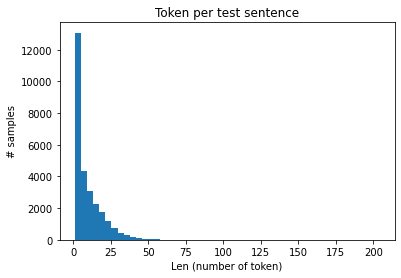

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

4045
Temporary
0
I-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 6934
Points in y_train before removal: 6934


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[8485, 14629, 4676]
[3, 3, 3]
[27510, 13880, 24183, 12605, 18868, 2286, 13149, 26441, 18810, 6328, 10914, 11897]
[2, 4, 4, 4, 4, 4, 3, 6, 1, 1, 1, 3]
[8570, 13812, 4676]
[3, 3, 3]
4045
0
B-problem
reticulocyte
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.8 MB/s 
     |████████████████████████████████| 120 kB 73.2 MB/s 
     |████████████████████████████████| 6.6 MB 69.9 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ca0e4b5c04cb298c88b56b2302053ab5611ed29c84d67314228cf39ea194812a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[8485, 14629, 4676]
[3, 3, 3]
[27510, 13880, 24183, 12605, 18868, 2286, 13149, 26441, 18810, 6328, 10914, 11897]
[2, 4, 4, 4, 4, 4, 3, 6, 1, 1, 1, 3]
[8570, 13812, 4676]
[3, 3, 3]
4045
0
B-problem
reticulocyte
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5635178089141846
Training loss per 100 training steps: 0.4194092181797075
Training loss per 100 training steps: 0.30129217652983925
Training loss epoch: 0.2912150033951355
Training accuracy epoch: 0.9089824398688698
Validating model...
Validation Loss: 0.1589316793463447
Validation Accuracy: 0.9497983077802893
Training epoch: 2
Training loss per 100 training steps: 0.09973916411399841
Training loss per 100 training steps: 0.10750758607346232
Training loss per 100 training steps: 0.10562813588747041
Training loss epoch: 0.10411877131029483
Training accuracy epoch: 0.9667867885760678
Validating model...
Validation Loss: 0.15759157795797696
Validation Accuracy: 0.9546269750598186
Training epoch: 3
Training loss per 100 training steps: 0.13816006481647491
Training loss per 100 training steps: 0.05962073319766781
Training loss per 100 training steps: 0.06098085502162576
Training loss epoch: 0.06097888791813485
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16111336136721852
Validation Accuracy: 0.9532364562255277
Validation duration: 2.3049568666666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.81      0.82      0.82     12546
        test       0.85      0.84      0.84      9012
   treatment       0.85      0.82      0.84      9297

   micro avg       0.83      0.83      0.83     30855
   macro avg       0.84      0.83      0.83     30855
weighted avg       0.83      0.83      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0004782676696777
Training loss per 100 training steps: 0.37534667396604426
Training loss per 100 training steps: 0.27978124413917316
Training loss epoch: 0.27332855773068243
Training accuracy epoch: 0.9133756802600785
Validating model...
Validation Loss: 0.16563593683304725
Validation Accuracy: 0.9469053890863542
Training epoch: 2
Training loss per 100 training steps: 0.2063615620136261
Training loss per 100 training steps: 0.10272631807123671
Training loss per 100 training steps: 0.10068205517915944
Training loss epoch: 0.10402785275938324
Training accuracy epoch: 0.9669159218137962
Validating model...
Validation Loss: 0.15004291936948702
Validation Accuracy: 0.9534253011679367
Training epoch: 3
Training loss per 100 training steps: 0.032686613500118256
Training loss per 100 training steps: 0.05947987860677266
Training loss per 100 training steps: 0.061802665561678544
Training loss epoch: 0.06249719141652026
Training accuracy e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15945685529624354
Validation Accuracy: 0.95158585637294
Validation duration: 1.9642758333333328 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.78      0.85      0.81     12546
        test       0.83      0.83      0.83      9012
   treatment       0.83      0.84      0.84      9297

   micro avg       0.81      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.81      0.84      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.091411590576172
Training loss per 100 training steps: 0.38516971461548666
Training loss per 100 training steps: 0.28426269781011254
Training loss epoch: 0.27636769312661363
Training accuracy epoch: 0.9143346513719589
Validating model...
Validation Loss: 0.1561945719378335
Validation Accuracy: 0.9501544914360545
Training epoch: 2
Training loss per 100 training steps: 0.05698864907026291
Training loss per 100 training steps: 0.09658048191283009
Training loss per 100 training steps: 0.10884825927923568
Training loss epoch: 0.10732712388931331
Training accuracy epoch: 0.9670004821499718
Validating model...
Validation Loss: 0.1470594499985893
Validation Accuracy: 0.955797633958097
Training epoch: 3
Training loss per 100 training steps: 0.0706450566649437
Training loss per 100 training steps: 0.05296087662901471
Training loss per 100 training steps: 0.05954930148045741
Training loss epoch: 0.059734131765341564
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14982054269057699
Validation Accuracy: 0.9551777084804507
Validation duration: 1.9332762666666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

     problem       0.82      0.86      0.84     12546
        test       0.82      0.87      0.84      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0774085521698
Training loss per 100 training steps: 0.39614447058722524
Training loss per 100 training steps: 0.2975000483702071
Training loss epoch: 0.2868914974999318
Training accuracy epoch: 0.9099197566928432
Validating model...
Validation Loss: 0.18655879790713262
Validation Accuracy: 0.9423603452304177
Training epoch: 2
Training loss per 100 training steps: 0.13871143758296967
Training loss per 100 training steps: 0.10893141588952282
Training loss per 100 training steps: 0.1097777147188931
Training loss epoch: 0.10755953587986494
Training accuracy epoch: 0.9663911607932
Validating model...
Validation Loss: 0.1585678802198404
Validation Accuracy: 0.9524191725030805
Training epoch: 3
Training loss per 100 training steps: 0.04039784148335457
Training loss per 100 training steps: 0.05276559921221273
Training loss per 100 training steps: 0.05946310848664882
Training loss epoch: 0.06001543736059545
Training accuracy epoch: 0.981

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.162192109174578
Validation Accuracy: 0.9515295986089163
Validation duration: 1.9484519500000033 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.82      0.86      0.84     12546
        test       0.77      0.88      0.82      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.80      0.87      0.83     30855
   macro avg       0.80      0.87      0.83     30855
weighted avg       0.80      0.87      0.83     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.146034002304077
Training loss per 100 training steps: 0.41653890656952813
Training loss per 100 training steps: 0.3002833365022543
Training loss epoch: 0.2926579757941209
Training accuracy epoch: 0.908499048554071
Validating model...
Validation Loss: 0.16532829423229417
Validation Accuracy: 0.9472089480968416
Training epoch: 2
Training loss per 100 training steps: 0.1344006359577179
Training loss per 100 training steps: 0.10425980988484208
Training loss per 100 training steps: 0.10330945557789571
Training loss epoch: 0.1022830849839589
Training accuracy epoch: 0.9671282655839418
Validating model...
Validation Loss: 0.16454889672481782
Validation Accuracy: 0.9529116054139825
Training epoch: 3
Training loss per 100 training steps: 0.05269273743033409
Training loss per 100 training steps: 0.05440507543337817
Training loss per 100 training steps: 0.05606760448354542
Training loss epoch: 0.05617378243944749
Training accuracy epoch: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1629183746624255
Validation Accuracy: 0.9526066065432421
Validation duration: 1.9459872666666647 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.85      0.87      0.86      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0226547718048096
Training loss per 100 training steps: 0.382400951836959
Training loss per 100 training steps: 0.28569282761853726
Training loss epoch: 0.2764729277192173
Training accuracy epoch: 0.9132962200004241
Validating model...
Validation Loss: 0.16711749063877315
Validation Accuracy: 0.9469277420322667
Training epoch: 2
Training loss per 100 training steps: 0.06844612956047058
Training loss per 100 training steps: 0.09463941600026175
Training loss per 100 training steps: 0.09707832020888132
Training loss epoch: 0.09728070533478178
Training accuracy epoch: 0.9692531195165083
Validating model...
Validation Loss: 0.15759736570444974
Validation Accuracy: 0.9518880750970328
Training epoch: 3
Training loss per 100 training steps: 0.012177761644124985
Training loss per 100 training steps: 0.04889963912583961
Training loss per 100 training steps: 0.052888709901188
Training loss epoch: 0.054402495856710156
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16256138632888906
Validation Accuracy: 0.9505368953386167
Validation duration: 1.9432530166666766 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.83     12546
        test       0.82      0.89      0.85      9012
   treatment       0.81      0.85      0.83      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9385817050933838
Training loss per 100 training steps: 0.40302959711539865
Training loss per 100 training steps: 0.29735898975264374
Training loss epoch: 0.28934422403161975
Training accuracy epoch: 0.9098885549930619
Validating model...
Validation Loss: 0.16076188669963318
Validation Accuracy: 0.9495230062841095
Training epoch: 2
Training loss per 100 training steps: 0.027151066809892654
Training loss per 100 training steps: 0.10644631006635062
Training loss per 100 training steps: 0.10450118574411121
Training loss epoch: 0.1030090583943277
Training accuracy epoch: 0.9679016260921258
Validating model...
Validation Loss: 0.1504809736189517
Validation Accuracy: 0.9531794015060141
Training epoch: 3
Training loss per 100 training steps: 0.013552296906709671
Training loss per 100 training steps: 0.05687882574182926
Training loss per 100 training steps: 0.05817441668231689
Training loss epoch: 0.05795909696116975
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15792679177549737
Validation Accuracy: 0.9531240020029375
Validation duration: 1.9478325166666612 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.82      0.83      0.82     12546
        test       0.86      0.86      0.86      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.265881299972534
Training loss per 100 training steps: 0.39493922800710884
Training loss per 100 training steps: 0.2936844054739274
Training loss epoch: 0.2850798648623277
Training accuracy epoch: 0.9103260890679203
Validating model...
Validation Loss: 0.16067130196017104
Validation Accuracy: 0.9486521373656859
Training epoch: 2
Training loss per 100 training steps: 0.18243737518787384
Training loss per 100 training steps: 0.0968693862715275
Training loss per 100 training steps: 0.10191813860070054
Training loss epoch: 0.1007117427422017
Training accuracy epoch: 0.9683678235660116
Validating model...
Validation Loss: 0.161892063480306
Validation Accuracy: 0.9552592089684889
Training epoch: 3
Training loss per 100 training steps: 0.041631124913692474
Training loss per 100 training steps: 0.05487147501513067
Training loss per 100 training steps: 0.05424222303091071
Training loss epoch: 0.05468967764033219
Training accuracy epoch: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17565004814672716
Validation Accuracy: 0.9542227286691741
Validation duration: 1.943241183333339 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.81      0.85      0.83     12546
        test       0.85      0.87      0.86      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1355032920837402
Training loss per 100 training steps: 0.36411710253151336
Training loss per 100 training steps: 0.2792185592228797
Training loss epoch: 0.2705188355653242
Training accuracy epoch: 0.9147713410049356
Validating model...
Validation Loss: 0.1631814552979036
Validation Accuracy: 0.9490936691011136
Training epoch: 2
Training loss per 100 training steps: 0.09150925278663635
Training loss per 100 training steps: 0.0907375415289166
Stopping epoch...
Training loss epoch: 0.0907375415289166
Training accuracy epoch: 0.9617431370130722
Validating model...
Validation Loss: 0.15785345171469373
Validation Accuracy: 0.9511715361449096
Training epoch: 3
Training loss per 100 training steps: 0.12090356647968292
Training loss per 100 training steps: 0.07689145826135237
Training loss per 100 training steps: 0.08234438878850113
Training loss epoch: 0.0824516856922738
Training accuracy epoch: 0.973905134556188
Validating model...
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15674125345389325
Validation Accuracy: 0.9541280486885009
Validation duration: 1.9449477666666704 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.82      0.86      0.84     12546
        test       0.85      0.87      0.86      9012
   treatment       0.81      0.86      0.84      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8768116235733032
Training loss per 100 training steps: 0.3843044558226472
Training loss per 100 training steps: 0.285711086545121
Training loss epoch: 0.2793661541721788
Training accuracy epoch: 0.9120429456716665
Validating model...
Validation Loss: 0.17086717442839178
Validation Accuracy: 0.9437997744401628
Training epoch: 2
Training loss per 100 training steps: 0.30075201392173767
Training loss per 100 training steps: 0.09802471577088431
Training loss per 100 training steps: 0.09870157982060565
Training loss epoch: 0.09857046336347607
Training accuracy epoch: 0.9689044524142721
Validating model...
Validation Loss: 0.15736640573104288
Validation Accuracy: 0.9549240984384615
Training epoch: 3
Training loss per 100 training steps: 0.05289195850491524
Training loss per 100 training steps: 0.057638392613112634
Training loss per 100 training steps: 0.059289744751648374
Training loss epoch: 0.05872743204879802
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16168666196797318
Validation Accuracy: 0.953997963113761
Validation duration: 1.9383627999999893 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.80      0.87      0.83     12546
        test       0.83      0.87      0.85      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6406131982803345
Training loss per 100 training steps: 0.3889070239545095
Training loss per 100 training steps: 0.28604367008404946
Training loss epoch: 0.25661691742849524
Training accuracy epoch: 0.921495847465985
Validating model...
Validation Loss: 0.17289810192275357
Validation Accuracy: 0.9417390692155938
Training epoch: 2
Training loss per 100 training steps: 0.06266658008098602
Training loss per 100 training steps: 0.104080144297516
Training loss per 100 training steps: 0.10056661204689771
Training loss epoch: 0.09710999147286055
Training accuracy epoch: 0.9684958709760243
Validating model...
Validation Loss: 0.1499241322472498
Validation Accuracy: 0.9551432417853831
Training epoch: 3
Training loss per 100 training steps: 0.06038212031126022
Training loss per 100 training steps: 0.04602639271536529
Training loss per 100 training steps: 0.050972078567769245
Training loss epoch: 0.05318897294320468
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16519150183928474
Validation Accuracy: 0.9516237623457765
Validation duration: 1.9233973000000029 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12546
        test       0.82      0.84      0.83      9012
   treatment       0.82      0.85      0.83      9297

   micro avg       0.81      0.84      0.83     30855
   macro avg       0.81      0.84      0.83     30855
weighted avg       0.81      0.84      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.301259994506836
Training loss per 100 training steps: 0.42692730664321693
Training loss per 100 training steps: 0.30993324362519964
Training loss epoch: 0.27564746131811196
Training accuracy epoch: 0.9147846755908338
Validating model...
Validation Loss: 0.17075568224702561
Validation Accuracy: 0.9429656767983391
Training epoch: 2
Training loss per 100 training steps: 0.11202729493379593
Training loss per 100 training steps: 0.10259321769053983
Training loss per 100 training steps: 0.10236934518246953
Training loss epoch: 0.10013923858295838
Training accuracy epoch: 0.968158776870789
Validating model...
Validation Loss: 0.15686362251252323
Validation Accuracy: 0.9541896082755966
Training epoch: 3
Training loss per 100 training steps: 0.033574119210243225
Training loss per 100 training steps: 0.052118317450000215
Training loss per 100 training steps: 0.05541709472485517
Training loss epoch: 0.0533291485617659
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17022931614256878
Validation Accuracy: 0.9494986315414998
Validation duration: 1.929513250000006 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.82     12546
        test       0.81      0.86      0.83      9012
   treatment       0.75      0.89      0.82      9297

   micro avg       0.78      0.87      0.82     30855
   macro avg       0.78      0.87      0.82     30855
weighted avg       0.78      0.87      0.82     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7564176321029663
Training loss per 100 training steps: 0.4114305139473169
Training loss per 100 training steps: 0.3013506006282657
Training loss epoch: 0.26646727997108577
Training accuracy epoch: 0.9175680161150532
Validating model...
Validation Loss: 0.1543692961915747
Validation Accuracy: 0.9495558319302061
Training epoch: 2
Training loss per 100 training steps: 0.05955422669649124
Training loss per 100 training steps: 0.10342897235019373
Training loss per 100 training steps: 0.09962561254422019
Training loss epoch: 0.10035960034319505
Training accuracy epoch: 0.968855572825164
Validating model...
Validation Loss: 0.15322527296647623
Validation Accuracy: 0.953701548776525
Training epoch: 3
Training loss per 100 training steps: 0.07834038883447647
Training loss per 100 training steps: 0.04643435404165694
Training loss per 100 training steps: 0.04919288221941288
Training loss epoch: 0.05126774688062303
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1646974338229349
Validation Accuracy: 0.9509966843496751
Validation duration: 1.9298994833333079 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.83      0.79      0.81     12546
        test       0.79      0.85      0.82      9012
   treatment       0.82      0.85      0.83      9297

   micro avg       0.81      0.83      0.82     30855
   macro avg       0.81      0.83      0.82     30855
weighted avg       0.81      0.83      0.82     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9695568084716797
Training loss per 100 training steps: 0.43264581189297213
Training loss per 100 training steps: 0.31170647196582896
Training loss epoch: 0.273570371661129
Training accuracy epoch: 0.9147300756359321
Validating model...
Validation Loss: 0.15831805201997232
Validation Accuracy: 0.9490573447835282
Training epoch: 2
Training loss per 100 training steps: 0.09959906339645386
Training loss per 100 training steps: 0.11030405337488887
Training loss per 100 training steps: 0.10277595985866156
Training loss epoch: 0.10371642815794561
Training accuracy epoch: 0.9673313791619019
Validating model...
Validation Loss: 0.15075846838873702
Validation Accuracy: 0.9546020671800398
Training epoch: 3
Training loss per 100 training steps: 0.05909322202205658
Training loss per 100 training steps: 0.05244966957367735
Training loss per 100 training steps: 0.05093361604819769
Training loss epoch: 0.05302666856072211
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16329998284022118
Validation Accuracy: 0.9505491508376186
Validation duration: 1.9281520500000018 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12546
        test       0.84      0.83      0.84      9012
   treatment       0.84      0.83      0.83      9297

   micro avg       0.82      0.83      0.83     30855
   macro avg       0.83      0.83      0.83     30855
weighted avg       0.82      0.83      0.83     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.904461145401001
Training loss per 100 training steps: 0.40039325689915384
Training loss per 100 training steps: 0.2942706715334114
Training loss epoch: 0.2594174697335356
Training accuracy epoch: 0.9186306859442293
Validating model...
Validation Loss: 0.15495331324153133
Validation Accuracy: 0.9496092863334974
Training epoch: 2
Training loss per 100 training steps: 0.06168001890182495
Training loss per 100 training steps: 0.08918016501656263
Training loss per 100 training steps: 0.09615682006178804
Training loss epoch: 0.0960583494378192
Training accuracy epoch: 0.9696400314031581
Validating model...
Validation Loss: 0.1626562690967089
Validation Accuracy: 0.9522225491865118
Training epoch: 3
Training loss per 100 training steps: 0.046788398176431656
Training loss per 100 training steps: 0.04725482678594123
Stopping epoch...
Training loss epoch: 0.04725482678594123
Training accuracy epoch: 0.9764499689538708
Validating model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15935879243598147
Validation Accuracy: 0.9493925744362032
Validation duration: 1.922711116666657 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.81      0.81      0.81     12546
        test       0.79      0.86      0.83      9012
   treatment       0.76      0.88      0.82      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.79      0.85      0.82     30855
weighted avg       0.79      0.85      0.82     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1262028217315674
Training loss per 100 training steps: 0.4192516461457356
Training loss per 100 training steps: 0.30362783153703554
Training loss epoch: 0.2683216117363684
Training accuracy epoch: 0.9144519611182944
Validating model...
Validation Loss: 0.1607667576376494
Validation Accuracy: 0.949688747803673
Training epoch: 2
Training loss per 100 training steps: 0.12749384343624115
Training loss per 100 training steps: 0.1076257038713977
Training loss per 100 training steps: 0.1028427032346082
Training loss epoch: 0.10243131624830275
Training accuracy epoch: 0.9673366711453838
Validating model...
Validation Loss: 0.14869237790343823
Validation Accuracy: 0.9568511977823189
Training epoch: 3
Training loss per 100 training steps: 0.037572912871837616
Training loss per 100 training steps: 0.05402331136738752
Training loss per 100 training steps: 0.051909920196535425
Training loss epoch: 0.05248278121866038
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15917672100045752
Validation Accuracy: 0.9529069024446154
Validation duration: 1.9353052666666675 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.84      0.84      0.84      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.82      0.85      0.83     30855
   macro avg       0.83      0.84      0.83     30855
weighted avg       0.82      0.85      0.83     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3110289573669434
Training loss per 100 training steps: 0.42066590856797625
Training loss per 100 training steps: 0.30950195692590815
Training loss epoch: 0.27360832604589935
Training accuracy epoch: 0.9155621857255365
Validating model...
Validation Loss: 0.14965652582513822
Validation Accuracy: 0.9517165997331365
Training epoch: 2
Training loss per 100 training steps: 0.05990166217088699
Training loss per 100 training steps: 0.0962149712745801
Training loss per 100 training steps: 0.09629621960000316
Training loss epoch: 0.09777466396756497
Training accuracy epoch: 0.9687514839671901
Validating model...
Validation Loss: 0.14973106895658103
Validation Accuracy: 0.954695404718929
Training epoch: 3
Training loss per 100 training steps: 0.1968381702899933
Training loss per 100 training steps: 0.0558770359447687
Training loss per 100 training steps: 0.054395491148423944
Training loss epoch: 0.05485829661988629
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1619146472183746
Validation Accuracy: 0.9491881076562481
Validation duration: 1.9353879999999966 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

     problem       0.79      0.82      0.80     12546
        test       0.82      0.85      0.83      9012
   treatment       0.78      0.87      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9050291776657104
Training loss per 100 training steps: 0.4042624136303911
Training loss per 100 training steps: 0.3056487614909808
Training loss epoch: 0.26767573896039454
Training accuracy epoch: 0.9172766715815529
Validating model...
Validation Loss: 0.16433357040990482
Validation Accuracy: 0.9501540626233717
Training epoch: 2
Training loss per 100 training steps: 0.12136708945035934
Training loss per 100 training steps: 0.10039904317127006
Training loss per 100 training steps: 0.10379233015747509
Training loss epoch: 0.10207723650215297
Training accuracy epoch: 0.9668732078715601
Validating model...
Validation Loss: 0.1524570643805064
Validation Accuracy: 0.9524701816382402
Training epoch: 3
Training loss per 100 training steps: 0.11318889260292053
Training loss per 100 training steps: 0.05162059906224656
Training loss per 100 training steps: 0.05471162837281341
Training loss epoch: 0.05711325372885431
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15620465582900647
Validation Accuracy: 0.9521249860559158
Validation duration: 1.921785949999988 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.82     12546
        test       0.82      0.87      0.85      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.981547236442566
Training loss per 100 training steps: 0.4068495569990413
Training loss per 100 training steps: 0.30609796613232415
Training loss epoch: 0.2687397318655054
Training accuracy epoch: 0.9166610509174733
Validating model...
Validation Loss: 0.1612352861405967
Validation Accuracy: 0.9497604803193395
Training epoch: 2
Training loss per 100 training steps: 0.07509946823120117
Training loss per 100 training steps: 0.10412365309709665
Training loss per 100 training steps: 0.10193539468747614
Training loss epoch: 0.10252355047367595
Training accuracy epoch: 0.9678153730050358
Validating model...
Validation Loss: 0.16489397686023216
Validation Accuracy: 0.953222438197682
Training epoch: 3
Training loss per 100 training steps: 0.10400988161563873
Training loss per 100 training steps: 0.05997854590618817
Training loss per 100 training steps: 0.058105906172752825
Training loss epoch: 0.05928770479371572
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1697779239815039
Validation Accuracy: 0.9461716685365652
Validation duration: 1.9355251166666676 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

     problem       0.75      0.84      0.79     12546
        test       0.84      0.81      0.82      9012
   treatment       0.77      0.86      0.81      9297

   micro avg       0.78      0.84      0.81     30855
   macro avg       0.79      0.84      0.81     30855
weighted avg       0.78      0.84      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 8668
Points in y_train after augmentation: 8668
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.152157783508301
Training loss per 100 training steps: 0.3872516988085048
Training loss per 100 training steps: 0.2932859023486204
Training loss epoch: 0.26343727066453093
Training accuracy epoch: 0.9178310355521802
Validating model...
Validation Loss: 0.16341555312082365
Validation Accuracy: 0.9466306255642659
Training epoch: 2
Training loss per 100 training steps: 0.07063352316617966
Training loss per 100 training steps: 0.09602726147611543
Training loss per 100 training steps: 0.09469167115305786
Training loss epoch: 0.09648605316492465
Training accuracy epoch: 0.9699063870258869
Validating model...
Validation Loss: 0.16533686660907485
Validation Accuracy: 0.953967329242347
Training epoch: 3
Training loss per 100 training steps: 0.051004741340875626
Training loss per 100 training steps: 0.05481623554842012
Training loss per 100 training steps: 0.052410417824835326
Training loss epoch: 0.05298306423796142
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15625299177029067
Validation Accuracy: 0.9499574908489768
Validation duration: 1.9243933499999912 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.0%
              precision    recall  f1-score   support

     problem       0.74      0.83      0.79     12546
        test       0.82      0.85      0.83      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.83      0.81     30855
weighted avg       0.79      0.83      0.81     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9812880754470825
Training loss per 100 training steps: 0.39478791630504156
Training loss per 100 training steps: 0.2850184582952243
Training loss per 100 training steps: 0.24112021460807403
Training loss epoch: 0.23395606906844613
Training accuracy epoch: 0.9279368921346758
Validating model...
Validation Loss: 0.16334340934242522
Validation Accuracy: 0.9511479988951179
Training epoch: 2
Training loss per 100 training steps: 0.08380930870771408
Training loss per 100 training steps: 0.09844363981507498
Training loss per 100 training steps: 0.09180461565282808
Training loss per 100 training steps: 0.08859941469771522
Training loss epoch: 0.08813398075718547
Training accuracy epoch: 0.9723099283248332
Validating model...
Validation Loss: 0.16458955874013437
Validation Accuracy: 0.9494840056173515
Training epoch: 3
Training loss per 100 training steps: 0.07718220353126526
Training loss per 100 training steps: 0.046075281325155995
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1759581201951261
Validation Accuracy: 0.9481078692113761
Validation duration: 1.9282226166666685 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.6%
              precision    recall  f1-score   support

     problem       0.82      0.79      0.80     12546
        test       0.86      0.82      0.84      9012
   treatment       0.79      0.83      0.81      9297

   micro avg       0.82      0.81      0.82     30855
   macro avg       0.82      0.82      0.82     30855
weighted avg       0.82      0.81      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.935813307762146
Training loss per 100 training steps: 0.4101582827544448
Training loss per 100 training steps: 0.3016615821354425
Training loss per 100 training steps: 0.25219048928481796
Training loss epoch: 0.24587470638434306
Training accuracy epoch: 0.9234349935055243
Validating model...
Validation Loss: 0.18281434969855592
Validation Accuracy: 0.940736876706501
Training epoch: 2
Training loss per 100 training steps: 0.10994694381952286
Training loss per 100 training steps: 0.0927696080306674
Training loss per 100 training steps: 0.09030404496956523
Training loss per 100 training steps: 0.09315456064461275
Training loss epoch: 0.09252994222369365
Training accuracy epoch: 0.9710600916136349
Validating model...
Validation Loss: 0.1588879847632987
Validation Accuracy: 0.9542190242113425
Training epoch: 3
Training loss per 100 training steps: 0.04877959191799164
Training loss per 100 training steps: 0.04498451986894159
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16910244451503753
Validation Accuracy: 0.9491935362688944
Validation duration: 1.9245052999999948 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

     problem       0.76      0.86      0.81     12546
        test       0.82      0.84      0.83      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.79      0.86      0.82     30855
   macro avg       0.80      0.85      0.83     30855
weighted avg       0.80      0.86      0.82     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0685412883758545
Training loss per 100 training steps: 0.38940966033404417
Training loss per 100 training steps: 0.2844523556567543
Training loss per 100 training steps: 0.2466840622358742
Training loss epoch: 0.2395875372697508
Training accuracy epoch: 0.9247849872565684
Validating model...
Validation Loss: 0.17585902970719647
Validation Accuracy: 0.9423893296988078
Training epoch: 2
Training loss per 100 training steps: 0.12321773916482925
Training loss per 100 training steps: 0.08983264821074387
Training loss per 100 training steps: 0.08888863176292744
Training loss per 100 training steps: 0.08781323369060244
Training loss epoch: 0.0874409955509144
Training accuracy epoch: 0.9731728450702345
Validating model...
Validation Loss: 0.16266135658536637
Validation Accuracy: 0.9509075133493491
Training epoch: 3
Training loss per 100 training steps: 0.014304335229098797
Training loss per 100 training steps: 0.050182226934645434
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1716470360708492
Validation Accuracy: 0.9493437068186166
Validation duration: 2.0882009666666517 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12547
        test       0.78      0.88      0.83      9012
   treatment       0.76      0.87      0.81      9299

   micro avg       0.78      0.86      0.82     30858
   macro avg       0.78      0.86      0.82     30858
weighted avg       0.78      0.86      0.82     30858

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.046266794204712
Training loss per 100 training steps: 0.41115830949332455
Training loss per 100 training steps: 0.30157669307432367
Training loss per 100 training steps: 0.2514345039214407
Training loss epoch: 0.2436925806733637
Training accuracy epoch: 0.9235635288223405
Validating model...
Validation Loss: 0.1528784300793301
Validation Accuracy: 0.9500122187316419
Training epoch: 2
Training loss per 100 training steps: 0.20119838416576385
Training loss per 100 training steps: 0.09414000396091159
Training loss per 100 training steps: 0.08967496360656782
Training loss per 100 training steps: 0.08801431426982646
Training loss epoch: 0.08705664289952042
Training accuracy epoch: 0.9727310770687057
Validating model...
Validation Loss: 0.168676741000918
Validation Accuracy: 0.9536723096759734
Training epoch: 3
Training loss per 100 training steps: 0.048682767897844315
Training loss per 100 training steps: 0.04897022406838023
Stopping

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15834602757348437
Validation Accuracy: 0.9489007768399853
Validation duration: 1.930827500000002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.76      0.85      0.80     12546
        test       0.82      0.87      0.84      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.80      0.85      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0654122829437256
Training loss per 100 training steps: 0.4092496102399165
Training loss per 100 training steps: 0.300863241860226
Training loss per 100 training steps: 0.2507176365690968
Training loss epoch: 0.2419948989901823
Training accuracy epoch: 0.9231230225576103
Validating model...
Validation Loss: 0.17715138022775773
Validation Accuracy: 0.9438134722478755
Training epoch: 2
Training loss per 100 training steps: 0.05588420480489731
Training loss per 100 training steps: 0.09272559952580987
Training loss per 100 training steps: 0.09314022210903873
Training loss per 100 training steps: 0.09352912055173783
Training loss epoch: 0.09351784657641239
Training accuracy epoch: 0.9701958161248028
Validating model...
Validation Loss: 0.1559139300960225
Validation Accuracy: 0.9538261856999563
Training epoch: 3
Training loss per 100 training steps: 0.013154223561286926
Training loss per 100 training steps: 0.04846327498296995
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1618929763833337
Validation Accuracy: 0.9519896251739839
Validation duration: 1.9344728999999765 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.78      0.85      0.82     12546
        test       0.83      0.86      0.85      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.768612265586853
Training loss per 100 training steps: 0.3765256508889765
Training loss per 100 training steps: 0.28486407023683114
Training loss per 100 training steps: 0.24509238975858966
Training loss epoch: 0.23680708861904093
Training accuracy epoch: 0.9258376850165688
Validating model...
Validation Loss: 0.1609802788921765
Validation Accuracy: 0.9468584918487396
Training epoch: 2
Training loss per 100 training steps: 0.10385707020759583
Training loss per 100 training steps: 0.08849751490103726
Training loss per 100 training steps: 0.08560591217927375
Training loss per 100 training steps: 0.08681010519869106
Training loss epoch: 0.08609454532616709
Training accuracy epoch: 0.9735955754760759
Validating model...
Validation Loss: 0.16872202188937696
Validation Accuracy: 0.9503296945724669
Training epoch: 3
Training loss per 100 training steps: 0.04740450903773308
Training loss per 100 training steps: 0.03978310148393053
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16582799289177205
Validation Accuracy: 0.9473187336729233
Validation duration: 1.918647349999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.81      0.86      0.83      9012
   treatment       0.82      0.81      0.82      9297

   micro avg       0.80      0.83      0.81     30855
   macro avg       0.80      0.83      0.82     30855
weighted avg       0.80      0.83      0.81     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9135680198669434
Training loss per 100 training steps: 0.388768571069335
Training loss per 100 training steps: 0.29063020950526147
Training loss per 100 training steps: 0.24877488625505043
Training loss epoch: 0.2415816449371675
Training accuracy epoch: 0.9255016016816877
Validating model...
Validation Loss: 0.15413310115116757
Validation Accuracy: 0.9509056193167214
Training epoch: 2
Training loss per 100 training steps: 0.12557323276996613
Training loss per 100 training steps: 0.0850689389217313
Training loss per 100 training steps: 0.08842279103153677
Training loss per 100 training steps: 0.08734335998797238
Training loss epoch: 0.08725393519085473
Training accuracy epoch: 0.9722992081258064
Validating model...
Validation Loss: 0.16629552013881796
Validation Accuracy: 0.9486429259020641
Training epoch: 3
Training loss per 100 training steps: 0.046927113085985184
Training loss per 100 training steps: 0.04791054508123215
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15873055584099213
Validation Accuracy: 0.950781695278031
Validation duration: 1.9416569166666402 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.8%
              precision    recall  f1-score   support

     problem       0.77      0.84      0.80     12546
        test       0.81      0.86      0.83      9012
   treatment       0.83      0.82      0.83      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9266433715820312
Training loss per 100 training steps: 0.40834816641146593
Training loss per 100 training steps: 0.30097715767906674
Training loss per 100 training steps: 0.25351706729502577
Training loss epoch: 0.24390318854340565
Training accuracy epoch: 0.923455640909958
Validating model...
Validation Loss: 0.16357558815703763
Validation Accuracy: 0.9497091396782923
Training epoch: 2
Training loss per 100 training steps: 0.08640474081039429
Training loss per 100 training steps: 0.09933803651002374
Training loss per 100 training steps: 0.0983091610117783
Training loss per 100 training steps: 0.09690895882679576
Training loss epoch: 0.09433191105083454
Training accuracy epoch: 0.9704199949886193
Validating model...
Validation Loss: 0.16982729445126923
Validation Accuracy: 0.9512208443075802
Training epoch: 3
Training loss per 100 training steps: 0.061642441898584366
Training loss per 100 training steps: 0.05109103376709736
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17077675447971732
Validation Accuracy: 0.9484967651000761
Validation duration: 1.9435795833333638 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

     problem       0.74      0.86      0.80     12546
        test       0.85      0.84      0.85      9012
   treatment       0.79      0.87      0.83      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.79      0.85      0.82     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9554848670959473
Training loss per 100 training steps: 0.416302949927821
Training loss per 100 training steps: 0.2996903692942057
Training loss per 100 training steps: 0.2550201368985382
Training loss epoch: 0.24852399737145636
Training accuracy epoch: 0.9229803735262411
Validating model...
Validation Loss: 0.17669950943295057
Validation Accuracy: 0.9452617982389957
Training epoch: 2
Training loss per 100 training steps: 0.06388803571462631
Training loss per 100 training steps: 0.09850326540077677
Training loss per 100 training steps: 0.09872094962504965
Training loss per 100 training steps: 0.09337243925396391
Training loss epoch: 0.09752688066108278
Training accuracy epoch: 0.96934619183818
Validating model...
Validation Loss: 0.1573495628529942
Validation Accuracy: 0.951451457288293
Training epoch: 3
Training loss per 100 training steps: 0.05585835874080658
Training loss per 100 training steps: 0.06274539210584641
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17117572245532992
Validation Accuracy: 0.9470116870205929
Validation duration: 1.9327272333333287 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.2%
              precision    recall  f1-score   support

     problem       0.77      0.82      0.80     12546
        test       0.85      0.80      0.82      9012
   treatment       0.83      0.82      0.83      9297

   micro avg       0.81      0.81      0.81     30855
   macro avg       0.82      0.81      0.81     30855
weighted avg       0.81      0.81      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9198081493377686
Training loss per 100 training steps: 0.41454673285531524
Training loss per 100 training steps: 0.3085676186639278
Training loss per 100 training steps: 0.25614268337670354
Training loss epoch: 0.24879899699857996
Training accuracy epoch: 0.9223509428530976
Validating model...
Validation Loss: 0.16158892018357654
Validation Accuracy: 0.9497127071221576
Training epoch: 2
Training loss per 100 training steps: 0.07342413812875748
Training loss per 100 training steps: 0.08065568954490199
Training loss per 100 training steps: 0.08520426816626717
Training loss per 100 training steps: 0.08791501676521428
Training loss epoch: 0.0897717510344335
Training accuracy epoch: 0.9707983005652127
Validating model...
Validation Loss: 0.17105044131832464
Validation Accuracy: 0.9508143037317651
Training epoch: 3
Training loss per 100 training steps: 0.046525124460458755
Training loss per 100 training steps: 0.08047416891976453
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1678556465819754
Validation Accuracy: 0.9459223592643469
Validation duration: 1.950247266666641 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.69      0.86      0.76     12546
        test       0.83      0.86      0.85      9012
   treatment       0.80      0.84      0.82      9297

   micro avg       0.76      0.85      0.80     30855
   macro avg       0.77      0.85      0.81     30855
weighted avg       0.76      0.85      0.80     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6059091091156006
Training loss per 100 training steps: 0.383038293533396
Training loss per 100 training steps: 0.28544932481513097
Training loss per 100 training steps: 0.24320612504979305
Training loss epoch: 0.221416303682092
Training accuracy epoch: 0.9311081794788494
Validating model...
Validation Loss: 0.16013120415971263
Validation Accuracy: 0.9506692759735075
Training epoch: 2
Training loss per 100 training steps: 0.04941901937127113
Training loss per 100 training steps: 0.08003284756352405
Training loss per 100 training steps: 0.07868747738426302
Training loss per 100 training steps: 0.07922944889103753
Training loss epoch: 0.0781664008458488
Training accuracy epoch: 0.9754352039590216
Validating model...
Validation Loss: 0.17289684403252292
Validation Accuracy: 0.9526646734373119
Training epoch: 3
Training loss per 100 training steps: 0.08254490047693253
Training loss per 100 training steps: 0.042762402903823424
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16495095387519407
Validation Accuracy: 0.949507097588563
Validation duration: 1.9440680833333317 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.78      0.82      0.80     12546
        test       0.82      0.86      0.84      9012
   treatment       0.84      0.81      0.83      9297

   micro avg       0.81      0.83      0.82     30855
   macro avg       0.81      0.83      0.82     30855
weighted avg       0.81      0.83      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1320648193359375
Training loss per 100 training steps: 0.4165072720682267
Training loss per 100 training steps: 0.3102720067720508
Training loss per 100 training steps: 0.26093003716926244
Training loss epoch: 0.2381508191361239
Training accuracy epoch: 0.9258263229042236
Validating model...
Validation Loss: 0.1506740991751869
Validation Accuracy: 0.9534004528654163
Training epoch: 2
Training loss per 100 training steps: 0.08374650031328201
Training loss per 100 training steps: 0.08616435964877653
Training loss per 100 training steps: 0.08386381719242875
Training loss per 100 training steps: 0.08560355474237984
Training loss epoch: 0.08430044127775257
Training accuracy epoch: 0.9736543304226791
Validating model...
Validation Loss: 0.16351241657099166
Validation Accuracy: 0.949836846736256
Training epoch: 3
Training loss per 100 training steps: 0.07023777067661285
Training loss per 100 training steps: 0.05249661870190118
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16156819138537953
Validation Accuracy: 0.9488388168917659
Validation duration: 1.9419164833333222 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.83      0.83      0.83      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.80      0.83      0.81     30855
   macro avg       0.81      0.83      0.82     30855
weighted avg       0.80      0.83      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1072394847869873
Training loss per 100 training steps: 0.4156398309929536
Training loss per 100 training steps: 0.30469984272077905
Training loss per 100 training steps: 0.2582606717671865
Training loss epoch: 0.23258597997360322
Training accuracy epoch: 0.9279478277175551
Validating model...
Validation Loss: 0.15818665762032783
Validation Accuracy: 0.9485837738697416
Training epoch: 2
Training loss per 100 training steps: 0.08600544929504395
Training loss per 100 training steps: 0.08897310689940016
Training loss per 100 training steps: 0.0905391517887587
Training loss per 100 training steps: 0.08771877398287438
Training loss epoch: 0.08689116510121446
Training accuracy epoch: 0.9732117725121366
Validating model...
Validation Loss: 0.16205610470338302
Validation Accuracy: 0.950964158818268
Training epoch: 3
Training loss per 100 training steps: 0.03837553411722183
Training loss per 100 training steps: 0.03737705594186883
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1584987341452183
Validation Accuracy: 0.9490535523055447
Validation duration: 1.9455511999999848 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

     problem       0.81      0.82      0.81     12546
        test       0.78      0.89      0.83      9012
   treatment       0.82      0.83      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1103880405426025
Training loss per 100 training steps: 0.4071666773888144
Training loss per 100 training steps: 0.2956338530007879
Training loss per 100 training steps: 0.25108693533908094
Training loss epoch: 0.22606074283585736
Training accuracy epoch: 0.9290690389826504
Validating model...
Validation Loss: 0.15302314863286234
Validation Accuracy: 0.9515842394600734
Training epoch: 2
Training loss per 100 training steps: 0.09712233394384384
Training loss per 100 training steps: 0.08366754813359516
Training loss per 100 training steps: 0.08362564185068976
Training loss per 100 training steps: 0.08365015118101309
Training loss epoch: 0.08430649918062906
Training accuracy epoch: 0.9732353005570404
Validating model...
Validation Loss: 0.16041151380964688
Validation Accuracy: 0.9491594546343239
Training epoch: 3
Training loss per 100 training steps: 0.03485601395368576
Training loss per 100 training steps: 0.03888238108449495
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1621359014351145
Validation Accuracy: 0.950692744996826
Validation duration: 1.959529866666647 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

     problem       0.79      0.82      0.81     12546
        test       0.86      0.85      0.85      9012
   treatment       0.82      0.80      0.81      9297

   micro avg       0.82      0.82      0.82     30855
   macro avg       0.82      0.82      0.82     30855
weighted avg       0.82      0.82      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.014092206954956
Training loss per 100 training steps: 0.3811319179759167
Training loss per 100 training steps: 0.292879434404385
Training loss per 100 training steps: 0.24369195076417288
Training loss epoch: 0.22115367990183202
Training accuracy epoch: 0.9314518148288811
Validating model...
Validation Loss: 0.15785428434126564
Validation Accuracy: 0.9522344183120096
Training epoch: 2
Training loss per 100 training steps: 0.047120869159698486
Training loss per 100 training steps: 0.07672851524398763
Training loss per 100 training steps: 0.07972287442720499
Training loss per 100 training steps: 0.08003594716732387
Training loss epoch: 0.07981514516286552
Training accuracy epoch: 0.9752000270797616
Validating model...
Validation Loss: 0.1549193553578157
Validation Accuracy: 0.9540538250356879
Training epoch: 3
Training loss per 100 training steps: 0.04260256513953209
Training loss per 100 training steps: 0.04203470928437713
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16760913996053947
Validation Accuracy: 0.9505248184106468
Validation duration: 1.9431830000000143 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.82     12546
        test       0.81      0.85      0.83      9012
   treatment       0.85      0.82      0.83      9297

   micro avg       0.81      0.84      0.83     30855
   macro avg       0.81      0.84      0.83     30855
weighted avg       0.81      0.84      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2487475872039795
Training loss per 100 training steps: 0.41194569275225745
Training loss per 100 training steps: 0.3005654926583245
Training loss per 100 training steps: 0.252636135466075
Training loss epoch: 0.23113154691496962
Training accuracy epoch: 0.9278424459932236
Validating model...
Validation Loss: 0.16196573549857388
Validation Accuracy: 0.9494136908277838
Training epoch: 2
Training loss per 100 training steps: 0.07734240591526031
Training loss per 100 training steps: 0.08686348932361838
Training loss per 100 training steps: 0.08965179591036554
Training loss per 100 training steps: 0.08581045341439718
Training loss epoch: 0.0833136858173499
Training accuracy epoch: 0.9736550132146425
Validating model...
Validation Loss: 0.16672125163596946
Validation Accuracy: 0.9526680830641608
Training epoch: 3
Training loss per 100 training steps: 0.020481420680880547
Training loss per 100 training steps: 0.04606484309170801
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16960435222696374
Validation Accuracy: 0.9469647160568443
Validation duration: 1.918353750000036 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.76      0.83      0.79     12546
        test       0.75      0.85      0.80      9012
   treatment       0.81      0.84      0.82      9297

   micro avg       0.77      0.84      0.80     30855
   macro avg       0.77      0.84      0.80     30855
weighted avg       0.77      0.84      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1404173374176025
Training loss per 100 training steps: 0.4056430186818142
Training loss per 100 training steps: 0.29419479819376076
Training loss per 100 training steps: 0.24672255771500723
Training loss epoch: 0.22399459537118674
Training accuracy epoch: 0.9310490659434882
Validating model...
Validation Loss: 0.15875975202236856
Validation Accuracy: 0.9503687975741615
Training epoch: 2
Training loss per 100 training steps: 0.08482113480567932
Training loss per 100 training steps: 0.07393700124161078
Training loss per 100 training steps: 0.0721453400189752
Training loss per 100 training steps: 0.07929082361492405
Training loss epoch: 0.07975715584807883
Training accuracy epoch: 0.9755607008383316
Validating model...
Validation Loss: 0.18190074673333725
Validation Accuracy: 0.9518483607403002
Training epoch: 3
Training loss per 100 training steps: 0.03404781222343445
Training loss per 100 training steps: 0.044875461981622594
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16058507292850496
Validation Accuracy: 0.9497579970283613
Validation duration: 1.9412130499999571 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.82      0.78      0.80     12546
        test       0.82      0.87      0.85      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.82      0.82      0.82     30855
   macro avg       0.82      0.82      0.82     30855
weighted avg       0.82      0.82      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8013114929199219
Training loss per 100 training steps: 0.39459911962546923
Training loss per 100 training steps: 0.2963971012452645
Training loss per 100 training steps: 0.2514128029049433
Training loss epoch: 0.22857221540455755
Training accuracy epoch: 0.9286314267584718
Validating model...
Validation Loss: 0.1614625004978923
Validation Accuracy: 0.9508668057492637
Training epoch: 2
Training loss per 100 training steps: 0.05257276073098183
Training loss per 100 training steps: 0.09215742309052165
Training loss per 100 training steps: 0.09046787402560165
Training loss per 100 training steps: 0.08614663679486889
Training loss epoch: 0.084665982131111
Training accuracy epoch: 0.9731433544333558
Validating model...
Validation Loss: 0.16004109655978618
Validation Accuracy: 0.9536192855476482
Training epoch: 3
Training loss per 100 training steps: 0.049974843859672546
Training loss per 100 training steps: 0.03877879740983838
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16636936174796169
Validation Accuracy: 0.9538041611292907
Validation duration: 1.9398521500000545 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12546
        test       0.82      0.89      0.85      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2000555992126465
Training loss per 100 training steps: 0.4193833493212662
Training loss per 100 training steps: 0.30721136786747927
Training loss per 100 training steps: 0.2604544436515764
Training loss epoch: 0.23494008064858224
Training accuracy epoch: 0.9267839214134587
Validating model...
Validation Loss: 0.16096875710146769
Validation Accuracy: 0.9464492344658122
Training epoch: 2
Training loss per 100 training steps: 0.20449437201023102
Training loss per 100 training steps: 0.09580362158467864
Training loss per 100 training steps: 0.09285215014100667
Training loss per 100 training steps: 0.0901982301468667
Training loss epoch: 0.09126273141683716
Training accuracy epoch: 0.9717727315329237
Validating model...
Validation Loss: 0.17518410967154938
Validation Accuracy: 0.9468529219555891
Training epoch: 3
Training loss per 100 training steps: 0.06918428838253021
Training loss per 100 training steps: 0.04750385849810399
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17069805663561932
Validation Accuracy: 0.9447205438979546
Validation duration: 1.940103066666658 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.0%
              precision    recall  f1-score   support

     problem       0.74      0.82      0.77     12546
        test       0.82      0.88      0.85      9012
   treatment       0.79      0.85      0.82      9297

   micro avg       0.78      0.85      0.81     30855
   macro avg       0.78      0.85      0.81     30855
weighted avg       0.78      0.85      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 12135
Points in y_train after augmentation: 12135
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7968411445617676
Training loss per 100 training steps: 0.40729630930293903
Training loss per 100 training steps: 0.3007011002124245
Training loss per 100 training steps: 0.2554636472384399
Training loss epoch: 0.23225441200560645
Training accuracy epoch: 0.9275321795178301
Validating model...
Validation Loss: 0.15462660557263858
Validation Accuracy: 0.9523987771986755
Training epoch: 2
Training loss per 100 training steps: 0.12092369049787521
Training loss per 100 training steps: 0.0751019940794547
Training loss per 100 training steps: 0.08023329882127284
Training loss per 100 training steps: 0.0842375546211123
Training loss epoch: 0.08295522101321502
Training accuracy epoch: 0.9741801119413858
Validating model...
Validation Loss: 0.1542895319448276
Validation Accuracy: 0.955064526669174
Training epoch: 3
Training loss per 100 training steps: 0.030572090297937393
Training loss per 100 training steps: 0.04223176753517277
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16760364386115084
Validation Accuracy: 0.9519094868689122
Validation duration: 1.942489683333406 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.81      0.83      0.82     12546
        test       0.80      0.86      0.83      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9476979970932007
Training loss per 100 training steps: 0.3976114871773389
Training loss per 100 training steps: 0.2928439200814091
Training loss per 100 training steps: 0.24974826765416863
Training loss per 100 training steps: 0.2211682165408521
Training loss epoch: 0.21498547969085555
Training accuracy epoch: 0.9339088498960751
Validating model...
Validation Loss: 0.16185149802015975
Validation Accuracy: 0.9471544366498635
Training epoch: 2
Training loss per 100 training steps: 0.04632124677300453
Training loss per 100 training steps: 0.06939820711049113
Training loss per 100 training steps: 0.07454897415828868
Training loss per 100 training steps: 0.07732609371527831
Training loss per 100 training steps: 0.07775303490223023
Training loss epoch: 0.07830253098061317
Training accuracy epoch: 0.9762899619334373
Validating model...
Validation Loss: 0.1685324227316426
Validation Accuracy: 0.9522841346891012
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17215942979372037
Validation Accuracy: 0.9461258138638597
Validation duration: 2.092767333333298 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.6%
              precision    recall  f1-score   support

     problem       0.81      0.77      0.79     12547
        test       0.82      0.85      0.83      9012
   treatment       0.80      0.86      0.83      9299

   micro avg       0.81      0.82      0.82     30858
   macro avg       0.81      0.83      0.82     30858
weighted avg       0.81      0.82      0.82     30858

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9036492109298706
Training loss per 100 training steps: 0.4041432925675175
Training loss per 100 training steps: 0.2929711790375449
Training loss per 100 training steps: 0.25126454846754026
Training loss per 100 training steps: 0.22015860392491418
Training loss epoch: 0.21529987547975807
Training accuracy epoch: 0.9327097924444345
Validating model...
Validation Loss: 0.1546069730992441
Validation Accuracy: 0.9513880616207333
Training epoch: 2
Training loss per 100 training steps: 0.08632177114486694
Training loss per 100 training steps: 0.08109270553980576
Training loss per 100 training steps: 0.07970930124165036
Training loss per 100 training steps: 0.07918109564556186
Training loss per 100 training steps: 0.07776453096925878
Training loss epoch: 0.0780022856768667
Training accuracy epoch: 0.9757609125022411
Validating model...
Validation Loss: 0.15514572675932536
Validation Accuracy: 0.9539479019830783
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16274406918522868
Validation Accuracy: 0.9487608861508394
Validation duration: 1.9206145666666998 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.74      0.84      0.79     12546
        test       0.83      0.83      0.83      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.79      0.84      0.81     30855
   macro avg       0.80      0.84      0.81     30855
weighted avg       0.79      0.84      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.031956672668457
Training loss per 100 training steps: 0.3984960695304493
Training loss per 100 training steps: 0.2926005622492501
Training loss per 100 training steps: 0.24733755650908448
Training loss per 100 training steps: 0.21999606597899202
Training loss epoch: 0.21195161548627686
Training accuracy epoch: 0.9335581590937745
Validating model...
Validation Loss: 0.173469073006085
Validation Accuracy: 0.9478682212372824
Training epoch: 2
Training loss per 100 training steps: 0.07067237794399261
Training loss per 100 training steps: 0.07272698614045535
Training loss per 100 training steps: 0.07576933798301427
Training loss per 100 training steps: 0.07559452103481835
Training loss per 100 training steps: 0.07614020258188248
Training loss epoch: 0.07601346261370155
Training accuracy epoch: 0.9755333576954524
Validating model...
Validation Loss: 0.16681088274949557
Validation Accuracy: 0.9524702759024867
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17832612860473562
Validation Accuracy: 0.9508044283538479
Validation duration: 1.9269456833334213 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.81      0.82      0.81     12546
        test       0.83      0.85      0.84      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.168950319290161
Training loss per 100 training steps: 0.39273670020669993
Training loss per 100 training steps: 0.2959596609965486
Training loss per 100 training steps: 0.25031323053957616
Training loss per 100 training steps: 0.2242581683427021
Training loss epoch: 0.216482445769321
Training accuracy epoch: 0.9325015912846527
Validating model...
Validation Loss: 0.1577902850876381
Validation Accuracy: 0.9509797374080043
Training epoch: 2
Training loss per 100 training steps: 0.10257035493850708
Training loss per 100 training steps: 0.08846840920793538
Training loss per 100 training steps: 0.0822311428268973
Training loss per 100 training steps: 0.07707827375811893
Training loss per 100 training steps: 0.08052035049300761
Training loss epoch: 0.08082745219945633
Training accuracy epoch: 0.9746178765329493
Validating model...
Validation Loss: 0.15440409628118013
Validation Accuracy: 0.9532639495116797
Training epoch: 3
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17114961437699902
Validation Accuracy: 0.9482665763851176
Validation duration: 1.9363249999999728 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.75      0.86      0.80     12546
        test       0.84      0.84      0.84      9012
   treatment       0.81      0.86      0.84      9297

   micro avg       0.79      0.86      0.82     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.79      0.86      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9822511672973633
Training loss per 100 training steps: 0.41377978034243723
Training loss per 100 training steps: 0.30105986383127337
Training loss per 100 training steps: 0.2515906450583095
Training loss per 100 training steps: 0.22420862396050273
Training loss epoch: 0.21664873226910555
Training accuracy epoch: 0.9322298639476232
Validating model...
Validation Loss: 0.1638708920157575
Validation Accuracy: 0.9493634360059353
Training epoch: 2
Training loss per 100 training steps: 0.07420819252729416
Training loss per 100 training steps: 0.07561731064636813
Training loss per 100 training steps: 0.07704528505955614
Training loss per 100 training steps: 0.07368546575338787
Training loss per 100 training steps: 0.0732267433998089
Training loss epoch: 0.07492303835927651
Training accuracy epoch: 0.976766392641761
Validating model...
Validation Loss: 0.17373296440663663
Validation Accuracy: 0.9495392942420995
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16771596027063895
Validation Accuracy: 0.9469056795172627
Validation duration: 1.9360649999999926 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

     problem       0.76      0.86      0.81     12546
        test       0.77      0.89      0.82      9012
   treatment       0.80      0.84      0.82      9297

   micro avg       0.77      0.86      0.81     30855
   macro avg       0.78      0.86      0.82     30855
weighted avg       0.77      0.86      0.81     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3339340686798096
Training loss per 100 training steps: 0.40567637375085663
Training loss per 100 training steps: 0.2930037963078983
Training loss per 100 training steps: 0.2492433436388193
Training loss per 100 training steps: 0.22337962986618057
Training loss epoch: 0.21666863373124517
Training accuracy epoch: 0.9326989332533264
Validating model...
Validation Loss: 0.16494572719002698
Validation Accuracy: 0.9487268834488246
Training epoch: 2
Training loss per 100 training steps: 0.11574205756187439
Training loss per 100 training steps: 0.08723815422652677
Training loss per 100 training steps: 0.08800459647115635
Training loss per 100 training steps: 0.08214996347630836
Training loss per 100 training steps: 0.07875659392840063
Training loss epoch: 0.0782634765789565
Training accuracy epoch: 0.9763349047597153
Validating model...
Validation Loss: 0.17229202694513582
Validation Accuracy: 0.9509456949409398
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.161538228540276
Validation Accuracy: 0.9497259528706146
Validation duration: 1.9321592500000406 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

     problem       0.77      0.86      0.81     12546
        test       0.81      0.86      0.84      9012
   treatment       0.85      0.80      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1216330528259277
Training loss per 100 training steps: 0.4114040634272122
Training loss per 100 training steps: 0.3005134730011373
Training loss per 100 training steps: 0.2536556732119912
Training loss per 100 training steps: 0.22693827512332626
Training loss epoch: 0.21853924350392434
Training accuracy epoch: 0.9325083937194576
Validating model...
Validation Loss: 0.16373176524391422
Validation Accuracy: 0.9507580768913392
Training epoch: 2
Training loss per 100 training steps: 0.033757757395505905
Training loss per 100 training steps: 0.07000084818884877
Training loss per 100 training steps: 0.07601241933747162
Training loss per 100 training steps: 0.07554122152741367
Training loss per 100 training steps: 0.07619359562791271
Training loss epoch: 0.0758446887465975
Training accuracy epoch: 0.9767734166224579
Validating model...
Validation Loss: 0.1708307864458917
Validation Accuracy: 0.9514855131854036
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1726248252067577
Validation Accuracy: 0.9483772667548633
Validation duration: 1.9311230333332787 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.77      0.84      0.81     12546
        test       0.78      0.85      0.81      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.78      0.84      0.81     30855
   macro avg       0.78      0.84      0.81     30855
weighted avg       0.78      0.84      0.81     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9720650911331177
Training loss per 100 training steps: 0.375123532396732
Training loss per 100 training steps: 0.27853054675593303
Training loss per 100 training steps: 0.23891427210745622
Training loss per 100 training steps: 0.21449736080264808
Training loss epoch: 0.20873147492996558
Training accuracy epoch: 0.9353739873417942
Validating model...
Validation Loss: 0.16529432618869588
Validation Accuracy: 0.949194610161532
Training epoch: 2
Training loss per 100 training steps: 0.07685285806655884
Training loss per 100 training steps: 0.07514548090535521
Training loss per 100 training steps: 0.07553197487966339
Training loss per 100 training steps: 0.07421976507972443
Training loss per 100 training steps: 0.07390054054511827
Training loss epoch: 0.0733815652515722
Training accuracy epoch: 0.9770965574350552
Validating model...
Validation Loss: 0.16836778064826866
Validation Accuracy: 0.951744898721714
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16372217884916743
Validation Accuracy: 0.9485858640097817
Validation duration: 1.9485400500000347 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.77      0.84      0.80     12546
        test       0.83      0.84      0.84      9012
   treatment       0.80      0.85      0.82      9297

   micro avg       0.79      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.79      0.84      0.82     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1587917804718018
Training loss per 100 training steps: 0.40806366119644427
Training loss per 100 training steps: 0.3003500934634636
Training loss per 100 training steps: 0.2546469982948612
Training loss per 100 training steps: 0.22807974502574327
Training loss epoch: 0.22030914450828243
Training accuracy epoch: 0.9309836176690135
Validating model...
Validation Loss: 0.1495608753198153
Validation Accuracy: 0.952410317238082
Training epoch: 2
Training loss per 100 training steps: 0.09876362979412079
Training loss per 100 training steps: 0.08170317591048114
Training loss per 100 training steps: 0.07608193231385145
Training loss per 100 training steps: 0.07525802503008878
Training loss per 100 training steps: 0.07518408496276548
Training loss epoch: 0.07551328097963662
Training accuracy epoch: 0.9761157450713678
Validating model...
Validation Loss: 0.17165638733800356
Validation Accuracy: 0.9515355974450713
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1651065526551705
Validation Accuracy: 0.9480787681784177
Validation duration: 1.9425737500000346 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

     problem       0.78      0.82      0.80     12546
        test       0.79      0.82      0.81      9012
   treatment       0.79      0.85      0.82      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.83      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13868
Points in y_train after augmentation: 13868
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1434340476989746
Training loss per 100 training steps: 0.421963898262175
Training loss per 100 training steps: 0.30820497540543923
Training loss per 100 training steps: 0.2610164472455796
Training loss per 100 training steps: 0.23306025270177538
Training loss epoch: 0.22494935721570994
Training accuracy epoch: 0.9309872522158076
Validating model...
Validation Loss: 0.17271399101266613
Validation Accuracy: 0.9470828048764373
Training epoch: 2
Training loss per 100 training steps: 0.05945175513625145
Training loss per 100 training steps: 0.07533971536535733
Training loss per 100 training steps: 0.07959628159374889
Training loss per 100 training steps: 0.07859984489368195
Training loss per 100 training steps: 0.07872776758329864
Training loss epoch: 0.07943220426809162
Training accuracy epoch: 0.9750512284348074
Validating model...
Validation Loss: 0.16756465339234897
Validation Accuracy: 0.9495153213551097
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1767967380777312
Validation Accuracy: 0.9481912432693328
Validation duration: 1.9217637500000515 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.8%
              precision    recall  f1-score   support

     problem       0.79      0.82      0.81     12546
        test       0.80      0.85      0.83      9012
   treatment       0.80      0.86      0.83      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9677752256393433
Training loss per 100 training steps: 0.4044261000829168
Training loss per 100 training steps: 0.3014815855789837
Training loss per 100 training steps: 0.25613826611063806
Training loss per 100 training steps: 0.2266556279004512
Training loss per 100 training steps: 0.20639371499419212
Training loss per 100 training steps: 0.19062359066689372
Training loss epoch: 0.18474615823918134
Training accuracy epoch: 0.9429986784731585
Validating model...
Validation Loss: 0.1582672521955781
Validation Accuracy: 0.9506397342737751
Training epoch: 2
Training loss per 100 training steps: 0.033693939447402954
Training loss per 100 training steps: 0.06279383692890406
Training loss per 100 training steps: 0.06338761945194867
Training loss per 100 training steps: 0.06310600444575482
Training loss per 100 training steps: 0.06403711579270903
Training loss per 100 training steps: 0.06424241144946236
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16094812090698354
Validation Accuracy: 0.9490453182278
Validation duration: 1.9235666333333938 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.78      0.83      0.81     12546
        test       0.78      0.88      0.82      9012
   treatment       0.81      0.84      0.82      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.79      0.85      0.82     30855
weighted avg       0.79      0.85      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8368098735809326
Training loss per 100 training steps: 0.3760126405718303
Training loss per 100 training steps: 0.28348426624613615
Training loss per 100 training steps: 0.23893897383910082
Training loss per 100 training steps: 0.21310671266549247
Training loss per 100 training steps: 0.19433576090190702
Training loss per 100 training steps: 0.17957500028059803
Training loss epoch: 0.17328997412996908
Training accuracy epoch: 0.9461616026596992
Validating model...
Validation Loss: 0.1646342042398143
Validation Accuracy: 0.9488662710241869
Training epoch: 2
Training loss per 100 training steps: 0.03702041506767273
Training loss per 100 training steps: 0.05629486857111206
Training loss per 100 training steps: 0.05505993864985544
Training loss per 100 training steps: 0.05584980921658913
Training loss per 100 training steps: 0.05463237627095861
Training loss per 100 training steps: 0.05678063574174564
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17700412661414938
Validation Accuracy: 0.9467560584278487
Validation duration: 1.8993878833333535 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.81      0.82      0.82      9012
   treatment       0.76      0.86      0.81      9297

   micro avg       0.78      0.84      0.81     30855
   macro avg       0.78      0.84      0.81     30855
weighted avg       0.78      0.84      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7676328420639038
Training loss per 100 training steps: 0.3836776480668842
Training loss per 100 training steps: 0.28529142506828353
Training loss per 100 training steps: 0.2455696205166091
Training loss per 100 training steps: 0.21645749494098962
Training loss per 100 training steps: 0.1975418555581879
Training loss per 100 training steps: 0.1842155588632713
Training loss epoch: 0.17806047652082693
Training accuracy epoch: 0.9453132488628466
Validating model...
Validation Loss: 0.16968976546611106
Validation Accuracy: 0.9459496656862416
Training epoch: 2
Training loss per 100 training steps: 0.07916272431612015
Training loss per 100 training steps: 0.06746540081198557
Training loss per 100 training steps: 0.07321989486012515
Training loss per 100 training steps: 0.06918088248791637
Training loss per 100 training steps: 0.06743106481960587
Training loss per 100 training steps: 0.06754186246804372
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17685173726177136
Validation Accuracy: 0.9514628324058031
Validation duration: 1.9021100833332942 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.80      0.85      0.82     12546
        test       0.84      0.86      0.85      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9872757196426392
Training loss per 100 training steps: 0.3737934689858172
Training loss per 100 training steps: 0.27804945939364123
Training loss per 100 training steps: 0.24330453537528302
Training loss per 100 training steps: 0.217451299190001
Training loss per 100 training steps: 0.20232099972799153
Training loss per 100 training steps: 0.18870628008095178
Training loss epoch: 0.18284008789099587
Training accuracy epoch: 0.9434285981725375
Validating model...
Validation Loss: 0.1844445180099506
Validation Accuracy: 0.9428172507734899
Training epoch: 2
Training loss per 100 training steps: 0.1528536081314087
Training loss per 100 training steps: 0.0667336662899297
Training loss per 100 training steps: 0.060820163758147264
Training loss per 100 training steps: 0.061227827807857446
Training loss per 100 training steps: 0.060225022151982624
Training loss per 100 training steps: 0.062023622109768486
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17970479284176016
Validation Accuracy: 0.9485194669870737
Validation duration: 1.898650550000093 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

     problem       0.78      0.84      0.81     12546
        test       0.83      0.84      0.83      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.84      0.83     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.123772382736206
Training loss per 100 training steps: 0.38204268963620214
Training loss per 100 training steps: 0.2880242072527681
Training loss per 100 training steps: 0.2450857083638047
Training loss per 100 training steps: 0.21755427703670135
Training loss per 100 training steps: 0.19815826868106742
Training loss per 100 training steps: 0.18330658513575346
Training loss epoch: 0.17631422743464487
Training accuracy epoch: 0.945193574462852
Validating model...
Validation Loss: 0.16279772054645922
Validation Accuracy: 0.9491554569384154
Training epoch: 2
Training loss per 100 training steps: 0.03502155467867851
Training loss per 100 training steps: 0.06454658286996406
Training loss per 100 training steps: 0.06076591852959709
Training loss per 100 training steps: 0.061096849049939665
Training loss per 100 training steps: 0.05982746831153025
Training loss per 100 training steps: 0.059899696338542564
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17395329913253793
Validation Accuracy: 0.9472871962881348
Validation duration: 1.9061745500000447 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.79      0.82      0.80     12546
        test       0.83      0.82      0.82      9012
   treatment       0.80      0.86      0.83      9298

   micro avg       0.80      0.83      0.82     30856
   macro avg       0.81      0.83      0.82     30856
weighted avg       0.80      0.83      0.82     30856

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.033599853515625
Training loss per 100 training steps: 0.4042599159892243
Training loss per 100 training steps: 0.29401200479684186
Training loss per 100 training steps: 0.24427938198924462
Training loss per 100 training steps: 0.2175680285510131
Training loss per 100 training steps: 0.19852673856470876
Training loss per 100 training steps: 0.18363585908232433
Training loss epoch: 0.17730878864396393
Training accuracy epoch: 0.9451804991216888
Validating model...
Validation Loss: 0.1600696575138476
Validation Accuracy: 0.9481635129315845
Training epoch: 2
Training loss per 100 training steps: 0.11118925362825394
Training loss per 100 training steps: 0.05671102112841488
Training loss per 100 training steps: 0.05600971064127203
Training loss per 100 training steps: 0.05845230682273442
Training loss per 100 training steps: 0.06029537874750068
Training loss per 100 training steps: 0.061947942400972046
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16442663488150747
Validation Accuracy: 0.9491066853745213
Validation duration: 1.9122220666666787 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

     problem       0.79      0.83      0.81     12546
        test       0.82      0.85      0.83      9012
   treatment       0.80      0.86      0.83      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.003929615020752
Training loss per 100 training steps: 0.4054221386956696
Training loss per 100 training steps: 0.29193222509761946
Training loss per 100 training steps: 0.24451296245586437
Training loss per 100 training steps: 0.21593570546189003
Training loss per 100 training steps: 0.19762523499821236
Training loss per 100 training steps: 0.1834055150792424
Training loss epoch: 0.1779999393632152
Training accuracy epoch: 0.9452700214158887
Validating model...
Validation Loss: 0.17192480190620793
Validation Accuracy: 0.9451639135420121
Training epoch: 2
Training loss per 100 training steps: 0.06668777018785477
Training loss per 100 training steps: 0.06821645597125044
Training loss per 100 training steps: 0.06150853262278275
Training loss per 100 training steps: 0.06138386736713672
Training loss per 100 training steps: 0.06104241842822058
Training loss per 100 training steps: 0.06110730264689067
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1744477057859681
Validation Accuracy: 0.9455718872231221
Validation duration: 2.116984166666589 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.0%
              precision    recall  f1-score   support

     problem       0.78      0.79      0.79     12548
        test       0.81      0.83      0.82      9012
   treatment       0.81      0.86      0.83      9301

   micro avg       0.80      0.82      0.81     30861
   macro avg       0.80      0.82      0.81     30861
weighted avg       0.80      0.82      0.81     30861

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.173746347427368
Training loss per 100 training steps: 0.39506329492767256
Training loss per 100 training steps: 0.2959556135520413
Training loss per 100 training steps: 0.24960700234404434
Training loss per 100 training steps: 0.22372471642427313
Training loss per 100 training steps: 0.20351970577222145
Training loss per 100 training steps: 0.1890532710742881
Training loss epoch: 0.18286421858975965
Training accuracy epoch: 0.9435490838481833
Validating model...
Validation Loss: 0.1737670252559247
Validation Accuracy: 0.9457697156020677
Training epoch: 2
Training loss per 100 training steps: 0.07624442130327225
Training loss per 100 training steps: 0.0655025740956316
Training loss per 100 training steps: 0.06374087684848044
Training loss per 100 training steps: 0.06277663638332605
Training loss per 100 training steps: 0.06343916063301469
Training loss per 100 training steps: 0.06208793045915738
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18158893341185628
Validation Accuracy: 0.9433282209112456
Validation duration: 1.9262693333332814 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.9%
              precision    recall  f1-score   support

     problem       0.73      0.85      0.79     12546
        test       0.82      0.84      0.83      9012
   treatment       0.79      0.86      0.82      9297

   micro avg       0.77      0.85      0.81     30855
   macro avg       0.78      0.85      0.81     30855
weighted avg       0.77      0.85      0.81     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.289583444595337
Training loss per 100 training steps: 0.4009149562161748
Training loss per 100 training steps: 0.29452636956575495
Training loss per 100 training steps: 0.25225026878308615
Training loss per 100 training steps: 0.22273503797142732
Training loss per 100 training steps: 0.20356792980756708
Training loss per 100 training steps: 0.18870705776784363
Training loss epoch: 0.18250556848657112
Training accuracy epoch: 0.9434785265317616
Validating model...
Validation Loss: 0.15712515218788153
Validation Accuracy: 0.9498007968759167
Training epoch: 2
Training loss per 100 training steps: 0.06584049761295319
Training loss per 100 training steps: 0.06234551416617809
Training loss per 100 training steps: 0.06364940686976138
Training loss per 100 training steps: 0.06229253027872786
Training loss per 100 training steps: 0.062499717570623
Training loss per 100 training steps: 0.06213089401142192
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1738992764191978
Validation Accuracy: 0.9460612885188108
Validation duration: 1.9151191666666516 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.78      0.83      0.81     12546
        test       0.80      0.82      0.81      9012
   treatment       0.81      0.84      0.82      9297

   micro avg       0.80      0.83      0.81     30855
   macro avg       0.80      0.83      0.81     30855
weighted avg       0.80      0.83      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0794873237609863
Training loss per 100 training steps: 0.3632655282421867
Training loss per 100 training steps: 0.27149359639085346
Training loss per 100 training steps: 0.23035058301202085
Training loss per 100 training steps: 0.20553630896079866
Training loss per 100 training steps: 0.189270343809963
Training loss per 100 training steps: 0.17624799580237333
Training loss epoch: 0.1708453749714222
Training accuracy epoch: 0.9469417799814496
Validating model...
Validation Loss: 0.18049441186058057
Validation Accuracy: 0.9478881846935324
Training epoch: 2
Training loss per 100 training steps: 0.03432649374008179
Training loss per 100 training steps: 0.05779328053392986
Training loss per 100 training steps: 0.05559130182804827
Training loss per 100 training steps: 0.05484886879899672
Training loss per 100 training steps: 0.05499535912132248
Training loss per 100 training steps: 0.05719453129850462
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18574012204771861
Validation Accuracy: 0.9484666811087535
Validation duration: 1.9329244000000472 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.80      0.82      0.81     12546
        test       0.79      0.88      0.84      9012
   treatment       0.81      0.84      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.80      0.84      0.82     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8400285243988037
Training loss per 100 training steps: 0.373558268762461
Training loss per 100 training steps: 0.2811068898780429
Training loss per 100 training steps: 0.23511182260622218
Training loss per 100 training steps: 0.2094172215056687
Training loss per 100 training steps: 0.18999180227458595
Training loss per 100 training steps: 0.17614379963417617
Training loss per 100 training steps: 0.16345538247573307
Training loss per 100 training steps: 0.15575748853171512
Training loss per 100 training steps: 0.14735656940315195
Training loss per 100 training steps: 0.13989199599070656
Training loss per 100 training steps: 0.13439866094228275
Training loss per 100 training steps: 0.1290525127160398
Training loss per 100 training steps: 0.12394541714606745
Training loss epoch: 0.12394541714606745
Training accuracy epoch: 0.9617373164529577
Validating model...
Validation Loss: 0.18741511766399657
Validation Accuracy: 0.94561324169

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1985547605544087
Validation Accuracy: 0.944199005814731
Validation duration: 1.9298318166668953 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.76      0.82      0.79     12546
        test       0.80      0.82      0.81      9012
   treatment       0.80      0.84      0.82      9297

   micro avg       0.78      0.83      0.80     30855
   macro avg       0.78      0.83      0.81     30855
weighted avg       0.78      0.83      0.80     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8711493015289307
Training loss per 100 training steps: 0.37675071566706836
Training loss per 100 training steps: 0.27567869738040873
Training loss per 100 training steps: 0.23080102109854603
Training loss per 100 training steps: 0.20575206331035442
Training loss per 100 training steps: 0.18603007974634747
Training loss per 100 training steps: 0.17257313912551533
Training loss per 100 training steps: 0.16177958550566698
Training loss per 100 training steps: 0.15403872177925673
Training loss per 100 training steps: 0.1477463494647257
Training loss per 100 training steps: 0.14118164108199002
Training loss per 100 training steps: 0.13519679058849013
Training loss per 100 training steps: 0.12973201528096961
Training loss per 100 training steps: 0.12511957167103016
Training loss epoch: 0.12511957167103016
Training accuracy epoch: 0.9615916639494924
Validating model...
Validation Loss: 0.1825323532057273
Validation Accuracy: 0.94465083

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20250968011182355
Validation Accuracy: 0.9408652116475151
Validation duration: 1.9243579166667284 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.7%
              precision    recall  f1-score   support

     problem       0.76      0.82      0.79     12546
        test       0.79      0.83      0.81      9012
   treatment       0.73      0.87      0.79      9297

   micro avg       0.76      0.84      0.80     30855
   macro avg       0.76      0.84      0.80     30855
weighted avg       0.76      0.84      0.80     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0505480766296387
Training loss per 100 training steps: 0.35661528650486823
Training loss per 100 training steps: 0.26293565799940877
Training loss per 100 training steps: 0.22547110692409186
Training loss per 100 training steps: 0.19813744242574807
Training loss per 100 training steps: 0.18173214463059773
Training loss per 100 training steps: 0.16735269771129538
Training loss per 100 training steps: 0.15537231788039207
Training loss per 100 training steps: 0.14809817936824873
Training loss per 100 training steps: 0.14156678267087908
Training loss per 100 training steps: 0.13493207223447307
Training loss per 100 training steps: 0.12989027389231309
Training loss per 100 training steps: 0.12551786618688757
Training loss per 100 training steps: 0.12148810230549154
Training loss epoch: 0.12148810230549154
Training accuracy epoch: 0.9628122548912285
Validating model...
Validation Loss: 0.1914629518695466
Validation Accuracy: 0.9456177

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20239041142243272
Validation Accuracy: 0.9423395608353501
Validation duration: 1.896604500000103 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.0%
              precision    recall  f1-score   support

     problem       0.74      0.84      0.79     12546
        test       0.75      0.85      0.80      9012
   treatment       0.78      0.85      0.82      9297

   micro avg       0.76      0.85      0.80     30855
   macro avg       0.76      0.85      0.80     30855
weighted avg       0.76      0.85      0.80     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6523951292037964
Training loss per 100 training steps: 0.36967505817071045
Training loss per 100 training steps: 0.2767862857351849
Training loss per 100 training steps: 0.23319634958557117
Training loss per 100 training steps: 0.20650709504517087
Training loss per 100 training steps: 0.18689706349399632
Training loss per 100 training steps: 0.1736353688847007
Training loss per 100 training steps: 0.16411961843332704
Training loss per 100 training steps: 0.15382397623288535
Training loss per 100 training steps: 0.14601054910950767
Training loss per 100 training steps: 0.1390151688531339
Training loss per 100 training steps: 0.13305868493810932
Training loss per 100 training steps: 0.12831844899998815
Training loss per 100 training steps: 0.12395006999499426
Training loss epoch: 0.12395006999499426
Training accuracy epoch: 0.9616753613808502
Validating model...
Validation Loss: 0.1847817264255378
Validation Accuracy: 0.9469223775

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19611793884757422
Validation Accuracy: 0.9451992314115026
Validation duration: 2.123816133333215 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.0%
              precision    recall  f1-score   support

     problem       0.76      0.84      0.80     12548
        test       0.81      0.82      0.82      9012
   treatment       0.80      0.85      0.82      9301

   micro avg       0.78      0.84      0.81     30861
   macro avg       0.79      0.84      0.81     30861
weighted avg       0.78      0.84      0.81     30861

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1157948970794678
Training loss per 100 training steps: 0.39451283585317065
Training loss per 100 training steps: 0.2890421422522756
Training loss per 100 training steps: 0.24313426803661342
Training loss per 100 training steps: 0.21604929508599557
Training loss per 100 training steps: 0.1957063324258713
Training loss per 100 training steps: 0.18018112295987504
Training loss per 100 training steps: 0.16817043038395987
Training loss per 100 training steps: 0.15857496558480458
Training loss per 100 training steps: 0.1489909809200583
Training loss per 100 training steps: 0.14237917554132143
Training loss per 100 training steps: 0.13607957112525915
Training loss per 100 training steps: 0.13116629099896757
Training loss per 100 training steps: 0.12699262873408493
Training loss epoch: 0.12699262873408493
Training accuracy epoch: 0.960907407430765
Validating model...
Validation Loss: 0.1873156547836669
Validation Accuracy: 0.94135747236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20910062834284165
Validation Accuracy: 0.938078902578988
Validation duration: 1.9307746166666524 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.5%
              precision    recall  f1-score   support

     problem       0.77      0.78      0.77     12546
        test       0.72      0.80      0.76      9012
   treatment       0.73      0.87      0.79      9297

   micro avg       0.74      0.81      0.78     30855
   macro avg       0.74      0.82      0.77     30855
weighted avg       0.74      0.81      0.77     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.781720519065857
Training loss per 100 training steps: 0.361477884546955
Training loss per 100 training steps: 0.2675734051127932
Training loss per 100 training steps: 0.22726280861023654
Training loss per 100 training steps: 0.2035361483943953
Training loss per 100 training steps: 0.18533706731960445
Training loss per 100 training steps: 0.1713609649193862
Training loss per 100 training steps: 0.16254662071619072
Training loss per 100 training steps: 0.15382340899697702
Training loss per 100 training steps: 0.1457981128311746
Training loss per 100 training steps: 0.1395135445577966
Training loss per 100 training steps: 0.13348484069504837
Training loss per 100 training steps: 0.12837979967219695
Training loss per 100 training steps: 0.1240175827953973
Training loss epoch: 0.1240175827953973
Training accuracy epoch: 0.9622732669678602
Validating model...
Validation Loss: 0.20068605614269708
Validation Accuracy: 0.9452479279374909

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20449909374130787
Validation Accuracy: 0.9451971144454453
Validation duration: 1.927999366666821 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.5%
              precision    recall  f1-score   support

     problem       0.80      0.81      0.81     12546
        test       0.76      0.84      0.80      9012
   treatment       0.80      0.81      0.81      9297

   micro avg       0.79      0.82      0.81     30855
   macro avg       0.79      0.82      0.81     30855
weighted avg       0.79      0.82      0.81     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1476926803588867
Training loss per 100 training steps: 0.3786515729999778
Training loss per 100 training steps: 0.2850476265398424
Training loss per 100 training steps: 0.23551435074908195
Training loss per 100 training steps: 0.2093969252462176
Training loss per 100 training steps: 0.19105489673594872
Training loss per 100 training steps: 0.17680862261146654
Training loss per 100 training steps: 0.16525898276484133
Training loss per 100 training steps: 0.15592349360763244
Training loss per 100 training steps: 0.14713504709836744
Training loss per 100 training steps: 0.14059578820497362
Training loss per 100 training steps: 0.1349236845477847
Training loss per 100 training steps: 0.13048434249442584
Training loss per 100 training steps: 0.12579479697196216
Training loss epoch: 0.12579479697196216
Training accuracy epoch: 0.9614906623171675
Validating model...
Validation Loss: 0.18010419986948564
Validation Accuracy: 0.9477456962

In [ ]:
number_of_training_models = 4
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8082966804504395
Training loss per 100 training steps: 0.3565769239079834
Training loss per 100 training steps: 0.269153929394276
Training loss per 100 training steps: 0.22340143213289917
Training loss per 100 training steps: 0.19901589069171738
Training loss per 100 training steps: 0.1810658293778073
Training loss per 100 training steps: 0.16770141175366976
Training loss per 100 training steps: 0.15727692350915257
Training loss per 100 training steps: 0.1479478617002269
Training loss per 100 training steps: 0.1417645771282784
Training loss per 100 training steps: 0.1351778359425912
Training loss per 100 training steps: 0.13030793312911645
Training loss per 100 training steps: 0.1247583881030627
Training loss per 100 training steps: 0.12085253764466482
Training loss epoch: 0.12085253764466482
Training accuracy epoch: 0.9626085514885548
Validating model...
Validation Loss: 0.19065432608514638
Validation Accuracy: 0.94486434885362

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19478197640058137
Validation Accuracy: 0.943424085540407
Validation duration: 1.9093071333333305 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.3%
              precision    recall  f1-score   support

     problem       0.75      0.82      0.78     12546
        test       0.73      0.85      0.78      9012
   treatment       0.81      0.83      0.82      9297

   micro avg       0.76      0.83      0.79     30855
   macro avg       0.76      0.83      0.80     30855
weighted avg       0.76      0.83      0.79     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9695645570755005
Training loss per 100 training steps: 0.4024303632207436
Training loss per 100 training steps: 0.2884185802543638
Training loss per 100 training steps: 0.2434461755164438
Training loss per 100 training steps: 0.21544533248461245
Training loss per 100 training steps: 0.194028391441453
Training loss per 100 training steps: 0.17793700599984053
Training loss per 100 training steps: 0.16603934835807319
Training loss per 100 training steps: 0.15606837060195528
Training loss per 100 training steps: 0.14961727814424317
Training loss per 100 training steps: 0.14248915531623227
Training loss per 100 training steps: 0.1361985552555236
Training loss per 100 training steps: 0.1311548631382388
Training loss per 100 training steps: 0.12631797330521283
Training loss epoch: 0.12631797330521283
Training accuracy epoch: 0.9607753749524636
Validating model...
Validation Loss: 0.18856789805478863
Validation Accuracy: 0.9476628448769

In [9]:
number_of_training_models = 3
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1276581287384033
Training loss per 100 training steps: 0.3724216147888415
Training loss per 100 training steps: 0.27389828176863157
Training loss per 100 training steps: 0.23520272608809298
Training loss per 100 training steps: 0.21008815701837255
Training loss per 100 training steps: 0.19200163339998969
Training loss per 100 training steps: 0.17694928973274748
Training loss per 100 training steps: 0.16600541301608382
Training loss per 100 training steps: 0.1563947469870398
Training loss per 100 training steps: 0.14861070142891444
Training loss per 100 training steps: 0.14240235874576346
Training loss per 100 training steps: 0.1364516941466784
Training loss per 100 training steps: 0.13069379208942908
Training loss per 100 training steps: 0.12619718222117923
Training loss epoch: 0.12619718222117923
Training accuracy epoch: 0.9611504435279034
Validating model...
Validation Loss: 0.17760985051946981
Validation Accuracy: 0.947487675

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19679553181696166
Validation Accuracy: 0.9440027474606708
Validation duration: 2.0812912666666685 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

     problem       0.78      0.80      0.79     12547
        test       0.82      0.82      0.82      9012
   treatment       0.78      0.86      0.82      9299

   micro avg       0.79      0.82      0.81     30858
   macro avg       0.79      0.83      0.81     30858
weighted avg       0.79      0.82      0.81     30858

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.156162738800049
Training loss per 100 training steps: 0.3775928370138206
Training loss per 100 training steps: 0.27997610037822035
Training loss per 100 training steps: 0.2363555329879653
Training loss per 100 training steps: 0.2095139043038697
Training loss per 100 training steps: 0.1903005752995045
Training loss per 100 training steps: 0.1751847592974314
Training loss per 100 training steps: 0.16371324051240627
Training loss per 100 training steps: 0.1556339498827892
Training loss per 100 training steps: 0.14892769735471886
Training loss per 100 training steps: 0.14247419076741902
Training loss per 100 training steps: 0.13613193179248112
Training loss per 100 training steps: 0.13146557316469412
Training loss per 100 training steps: 0.12673838712349478
Training loss epoch: 0.12673838712349478
Training accuracy epoch: 0.9609135557501237
Validating model...
Validation Loss: 0.1848997947844592
Validation Accuracy: 0.94418807068918

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1900436338781017
Validation Accuracy: 0.9437440923270383
Validation duration: 1.9096839666666559 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.8%
              precision    recall  f1-score   support

     problem       0.76      0.80      0.78     12546
        test       0.78      0.84      0.81      9012
   treatment       0.79      0.85      0.82      9297

   micro avg       0.77      0.82      0.80     30855
   macro avg       0.77      0.83      0.80     30855
weighted avg       0.77      0.82      0.80     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 41604
Points in y_train after augmentation: 41604
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.932975172996521
Training loss per 100 training steps: 0.3829599651369718
Training loss per 100 training steps: 0.2798047593947667
Training loss per 100 training steps: 0.23401427469479286
Training loss per 100 training steps: 0.20721560061219477
Training loss per 100 training steps: 0.1895804554261193
Training loss per 100 training steps: 0.17536647238159636
Training loss per 100 training steps: 0.16451956616972338
Training loss per 100 training steps: 0.15475785402295072
Training loss per 100 training steps: 0.14749823675411325
Training loss per 100 training steps: 0.14081382287943459
Training loss per 100 training steps: 0.1347347049484136
Training loss per 100 training steps: 0.1293284014715727
Training loss per 100 training steps: 0.12530338001021576
Training loss epoch: 0.12530338001021576
Training accuracy epoch: 0.9613014983162185
Validating model...
Validation Loss: 0.18731887391828872
Validation Accuracy: 0.945860218532

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18929302473380058
Validation Accuracy: 0.9461928822857657
Validation duration: 1.9143685166666728 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

     problem       0.79      0.81      0.80     12546
        test       0.77      0.87      0.82      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.84      0.81     30855
weighted avg       0.79      0.83      0.81     30855

